<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [4]:
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read thru the documentation to accomplish this task. 

`Tip:` You will need to install the `bs4` library inside your conda environment. 

In [20]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
df = pd.read_csv('./data/job_listings.csv')
nlp = spacy.load("en_core_web_lg")

In [27]:
df['clean_description'] = df['description'].apply(lambda x: BeautifulSoup(x)
                                                  .get_text(strip=True)   #clear html tags
                                                  .replace('\\n', '') #remove new line markers
                                                  .replace("b\''", '')
                                                  .replace('\\xc2\\xa8ve', '') #remove this junk
#         '''BELOW FROM GITHUB'''
    .replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').#
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")"))


In [28]:
df['clean_description'][1]

'b\'Job DescriptionAs a Data Scientist 1, you will help us build machine learning models, data pipelines, and micro-services to help our clients navigate their healthcare journey. You will do so by empowering and improving the next generation of Accolade Applications and user experiences.A day in the life...Work with a small agile team to design and develop mobile applications in an iterative fashion.Work with a tight-knit group of development team members in Seattle.Contribute to best practices and help guide the future of our applications.Operates effectively as a collaborative member of the development team.Operates effectively as an individual for quick turnaround of enhancements and fixes.Responsible for meeting expectations and deliverables on time with high quality.Drive and implement new features within our mobile applications.Perform thorough manual testing and writing test cases that cover all areas.Identify new development tools/approaches that will increase code quality, ef

## 2) Use Spacy to tokenize the listings 

In [34]:
##### Your Code Here #####
df['tokens'] = [nlp(text) for text in df['clean_description']]
df['tokens'] = [[token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)]
                for doc in df['tokens']]

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [87]:
##### Your Code Here #####
vect = CountVectorizer(max_df=.97,
                       stop_words='english')
#fit countvectorizer with total corpora
vect.fit(df['clean_description'])
#create numpy array of counts
dtm = vect.transform(df['clean_description'])
#convert to DF
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

## 4) Visualize the most common word counts

In [88]:
##### Your Code Here #####
dtm.head()

,00,000,000pay,02115job,03,0356,04,062,06366,08,...,zenreach,zero,zeus,zf,zheng,zillow,zonesability,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Top 10 Most Common Job Description Keywods')

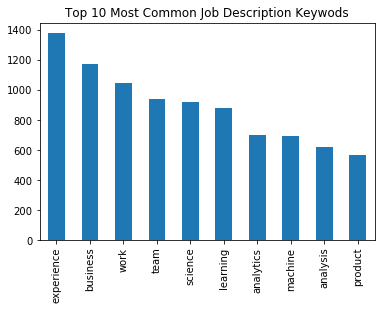

In [90]:
dtm.sum().sort_values(ascending=False)[:10].plot.bar()
plt.title('Top 10 Most Common Job Description Keywords')

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [91]:
def tokenize(document):
    doc = nlp(document)
    return [token.lemma_.strip() for token in doc if (token.is_stop == False) and (token.is_punct == False)]

In [94]:
##### Your Code Here #####
tfidf = TfidfVectorizer(max_df=.97,
                        stop_words='english',
                        ngram_range=(1,2),
                        tokenizer=tokenize)

tfidf.fit(df['clean_description'])
dtm = tfidf.transform(df['clean_description'])
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

In [95]:
dtm.head()

,$,"$ 1,000",$ 1.66,$ 10,"$ 100,000","$ 100,908",$ 10b,$ 110k,"$ 125,000","$ 126,062",...,|| santa,|| serveng,|| unite,|| ||,~$70,~$70 million,~1,~1 year)you,~4,~4 week
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.102228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [104]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

#testing fictional job listing
listing = ['Here is a clinical pharmacology job listing. Please know how to code! And how to spell!']
test = tfidf.transform(listing)
nn.kneighbors(test.todense())

(array([[1.11443413, 1.33099803, 1.35420032, 1.35611342, 1.35611342]]),
 array([[340, 150, 213,  81, 167]], dtype=int64))

In [105]:
df['clean_description'][340]

"b'POSITION OBJECTIVE:Provide efficient and effective programming solutions required for clinical pharmacology data analysis and reporting, including understanding clinical pharmacology components of study protocols, creation of more complex and integrated datasets, creation of graphs using more advanced programming skills, understanding and application of more advanced statistical tests, perform basic quality-checklist code reviews, develop standardized programs to automate routine tasks; and design, write and debug macro routines.This position will be located in either our Buffalo, New York office or our Cranford, New Jersey office.Essential Job Functions/ResponsibilitiesProvide clinical pharmacology statistical representation on project and protocol teams.Participate in the protocol development process, including sample size calculations and the statistical analysis plan section of the protocol.Perform bioequivalence (including food-effect, DDI, etc.) analysis and ad hoc statistical

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 